In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import random
import cv2

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras import regularizers, optimizers, layers, models, constraints 
from IPython.display import display
from tqdm import tqdm

random.seed()

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
LFW_VS_LFW_DEEPFUNNELED = 'lfw-deepfunneled'
INPUT_DATA = 'output_data'


In [3]:
# NN PARAMETERS
EPOCHS = 20
BATCH_SIZE = 100
LEARNING_RATE = 0.02
NUMBER_OF_NEURONS = 1024
REGULARIZATION_LAMBDA = 0.1

# CONVOLUTION PARAMETERS
IMG_SIZE = 160
CHANNELS = 3
NUM_OF_FEMALES = 3000
NUM_OF_MALES = 3000

In [4]:
def jj(*args):
    return os.path.join(*args)

def open_image(full_image_name):
#     return Image.open(full_image_name)
    flag = 1 if CHANNELS == 3 else 0
    return cv2.imread(full_image_name, flag)

def resize(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def convert_to_array(img):
    return np.array(img, ndmin=3)

def get_gender_dataset(gender, number_of_imgs):
    faces_list = []
    for img_name in tqdm(os.listdir(jj(INPUT_DATA, LFW_VS_LFW_DEEPFUNNELED))):
        if img_name.startswith(gender):
            path = jj(INPUT_DATA, LFW_VS_LFW_DEEPFUNNELED, img_name)
            img = open_image(path)
            resized_img = resize(img)
            array = convert_to_array(resized_img)
            label = 0 if gender == 'f' else 1
            faces_list.append((array, label))

    random.shuffle(faces_list)

    return faces_list[:number_of_imgs]

def get_dataset():
    females = get_gender_dataset('f', NUM_OF_FEMALES)
    males = get_gender_dataset('m', NUM_OF_MALES)
    dataset = females + males
    random.shuffle(dataset)
    
    return dataset


In [5]:
# Create dataset: [(np.array(), np.array()), (...), ...]
# CREATED ONCE, TEST DATASET MUST BE UNTOUCH!

# dataset = get_dataset()
# len(dataset)


100%|███████████████████████████████████| 13233/13233 [00:36<00:00, 360.11it/s]


5965

In [6]:
# Split dataset on train_and_validation dataset and test dataset
# CREATED ONCE, TEST DATASET MUST BE UNTOUCH!

# train_and_validation, test = train_test_split(dataset, test_size = 0.2, random_state = 0)
# x_test = np.asarray([i[0] for i in test])/255
# y_test = np.asarray([i[1] for i in test])

# WRITE DATASETS
# pickle.dump(train_and_validation, open("train_and_validation.data", "wb"))
# pickle.dump(test, open("test.data", "wb"))

# READA DATASETS
train_and_validation = pickle.load(open("train_and_validation.data", "rb"))
test = pickle.load(open("test.data", "rb"))


In [7]:
train, validation = train_test_split(train_and_validation, test_size = 0.25, random_state = 0)

x_train = np.asarray([i[0] for i in train])/255
y_train = np.asarray([i[1] for i in train])

x_validation = np.asarray([i[0] for i in validation])/255
y_validation = np.asarray([i[1] for i in validation])

In [8]:
# Pot loss
def show_loss(history):   
    x_axis = range(0, EPOCHS)
    fig, ax = plt.subplots()
    ax.plot(x_axis, history.history['loss'], label='train_loss')
    ax.plot(x_axis, history.history['val_loss'], label='val_loss')
    ax.legend()
    plt.ylabel('Log loss')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    
    plt.show()

In [9]:
# NN model

def nn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32,
                            kernel_size=(5,5),
                            strides=(1,1),
                            padding="same",
                            activation='relu',
                            use_bias=True,
                            kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA),                            
                            input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                           ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=64,
                            kernel_size=(5,5),
                            strides=(1,1),
                            padding="same",
                            activation='relu',
                            use_bias=True,
                            kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA),                           
                           ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(NUMBER_OF_NEURONS,
                           activation='relu',
                           kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA),
                          ))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimazier = optimizers.SGD(lr=LEARNING_RATE)
    model.compile(optimizer=optimazier,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# LOAD SAVED MODEL TO CONTINUE TRAINING
model = models.load_model("cnn.h5")

# model = nn_model()
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE)
score = model.evaluate(x_validation, y_validation, batch_size=BATCH_SIZE)
print(model.summary())


Train on 3340 samples, validate on 1432 samples
Epoch 1/30
3340/3340 [==============================] - ETA: 738s - loss: 207.1821 - acc: 0.460 - ETA: 516s - loss: 206.3589 - acc: 0.515 - ETA: 435s - loss: 205.5435 - acc: 0.516 - ETA: 372s - loss: 204.7204 - acc: 0.537 - ETA: 332s - loss: 203.9058 - acc: 0.532 - ETA: 305s - loss: 203.0986 - acc: 0.520 - ETA: 283s - loss: 202.3024 - acc: 0.505 - ETA: 266s - loss: 201.4791 - acc: 0.511 - ETA: 246s - loss: 200.6658 - acc: 0.511 - ETA: 231s - loss: 199.8560 - acc: 0.521 - ETA: 216s - loss: 199.0540 - acc: 0.519 - ETA: 205s - loss: 198.2525 - acc: 0.535 - ETA: 194s - loss: 197.4562 - acc: 0.546 - ETA: 182s - loss: 196.6664 - acc: 0.550 - ETA: 171s - loss: 195.8861 - acc: 0.550 - ETA: 160s - loss: 195.1127 - acc: 0.555 - ETA: 149s - loss: 194.3453 - acc: 0.561 - ETA: 140s - loss: 193.5837 - acc: 0.562 - ETA: 129s - loss: 192.8271 - acc: 0.568 - ETA: 120s - loss: 192.0759 - acc: 0.574 - ETA: 109s - loss: 191.3314 - acc: 0.571 - ETA: 100s - lo

3340/3340 [==============================] - ETA: 221s - loss: 14.1320 - acc: 0.75 - ETA: 212s - loss: 14.0463 - acc: 0.76 - ETA: 208s - loss: 13.9951 - acc: 0.77 - ETA: 200s - loss: 13.9363 - acc: 0.76 - ETA: 195s - loss: 13.8613 - acc: 0.78 - ETA: 188s - loss: 13.8085 - acc: 0.78 - ETA: 182s - loss: 13.7536 - acc: 0.78 - ETA: 175s - loss: 13.7051 - acc: 0.78 - ETA: 168s - loss: 13.6512 - acc: 0.78 - ETA: 161s - loss: 13.5983 - acc: 0.78 - ETA: 155s - loss: 13.5439 - acc: 0.78 - ETA: 148s - loss: 13.4877 - acc: 0.79 - ETA: 141s - loss: 13.4389 - acc: 0.79 - ETA: 134s - loss: 13.3867 - acc: 0.79 - ETA: 128s - loss: 13.3361 - acc: 0.79 - ETA: 120s - loss: 13.2800 - acc: 0.80 - ETA: 113s - loss: 13.2336 - acc: 0.79 - ETA: 107s - loss: 13.1867 - acc: 0.79 - ETA: 100s - loss: 13.1415 - acc: 0.79 - ETA: 93s - loss: 13.0911 - acc: 0.7930 - ETA: 86s - loss: 13.0395 - acc: 0.794 - ETA: 79s - loss: 12.9886 - acc: 0.794 - ETA: 72s - loss: 12.9411 - acc: 0.792 - ETA: 65s - loss: 12.8909 - acc: 0.

3340/3340 [==============================] - ETA: 239s - loss: 1.3828 - acc: 0.820 - ETA: 232s - loss: 1.3854 - acc: 0.815 - ETA: 227s - loss: 1.4161 - acc: 0.786 - ETA: 222s - loss: 1.4094 - acc: 0.792 - ETA: 219s - loss: 1.3945 - acc: 0.806 - ETA: 211s - loss: 1.3759 - acc: 0.820 - ETA: 205s - loss: 1.3815 - acc: 0.815 - ETA: 198s - loss: 1.3754 - acc: 0.813 - ETA: 191s - loss: 1.3699 - acc: 0.813 - ETA: 183s - loss: 1.3825 - acc: 0.799 - ETA: 176s - loss: 1.3893 - acc: 0.790 - ETA: 171s - loss: 1.3851 - acc: 0.791 - ETA: 163s - loss: 1.3798 - acc: 0.796 - ETA: 154s - loss: 1.3822 - acc: 0.790 - ETA: 146s - loss: 1.3765 - acc: 0.793 - ETA: 137s - loss: 1.3698 - acc: 0.796 - ETA: 129s - loss: 1.3666 - acc: 0.794 - ETA: 121s - loss: 1.3654 - acc: 0.789 - ETA: 113s - loss: 1.3586 - acc: 0.794 - ETA: 105s - loss: 1.3523 - acc: 0.796 - ETA: 97s - loss: 1.3474 - acc: 0.797 - ETA: 90s - loss: 1.3426 - acc: 0.79 - ETA: 82s - loss: 1.3380 - acc: 0.79 - ETA: 74s - loss: 1.3359 - acc: 0.79 - ET

dense_1 (Dense)              (None, 1024)              104858624 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 104,913,345
Trainable params: 104,913,345
Non-trainable params: 0
_________________________________________________________________
None
[0.57054183819440485, 0.81703910198291585]


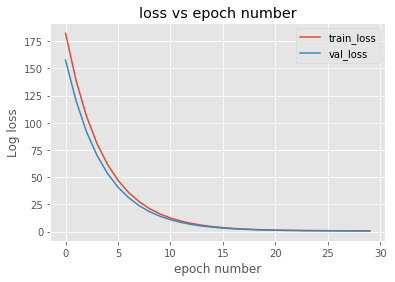

In [10]:
# Plot learning curves for validation and training data during learning
show_loss(history)

In [11]:
# SAVE MODEL TO A FILE
model.save("cnn.h5")